## Active Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sbi
sbi.__version__

'0.18.0'

In [3]:
import torch
from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.inference.potentials.base_potential import BasePotential

from copy import deepcopy

import matplotlib.pyplot as plt
from loss_calibration.active_learning import ActiveLearning

Prior and Simulator

In [4]:
prior =BoxUniform([-1], [1])
def sim(theta):
    return theta + torch.randn(theta.shape) * 0.2

In [5]:
class AcquisitionPotential(BasePotential):
    allow_iid_x = False
    def __init__(self, prior, x_o, device="cpu"):
        super().__init__(prior, x_o, device=device)
    
    def __call__(self, theta, track_gradients=True):
        with torch.set_grad_enabled(track_gradients):
            return torch.log(acquisition_fn(theta))


Define a cost function and an acquisition function

In [6]:
#cost_fn = StepLoss_weighted([2,1], 0.)    # ! torch.gt breaks backward pass of gradients
threshold = -0.8
threshold_dim = 0
costs = [2,1]

In [ ]:
save_dir = "./results/toy_example/active_learning/simple/"
al = ActiveLearning(prior=prior, simulator=sim, threshold=threshold, threshold_dim=threshold_dim, costs=costs, save_dir=save_dir)

In [ ]:
likelihood_estimator, postrior_estimator, potential, proposal = al.run(n_rounds=5)

Inspect learned proposal and potential

In [10]:
n_samples_proposal = 1000
samples_proposal = proposal.sample((n_samples_proposal,))
samples_prior = prior.sample((10,))

Drawing 1000 posterior samples: 1012it [00:03, 296.75it/s]                         


In [11]:
torch.save(samples_proposal, f"./results/toy_example/active_learning/simple_round{r+1}_sampled_theta.pt")

In [12]:
thetas_linspace = torch.linspace(prior.base_dist.low.item(),prior.base_dist.high.item(),1000).unsqueeze(1)
n_potentials = 50
potential_thetas_linspace = torch.stack([potential(thetas_linspace) for _ in range(n_potentials)])
# potential_thetas_linspace = torch.cat([torch.stack([potential(th) for th in thetas_linspace], dim=1) for r in range(n_potential)])

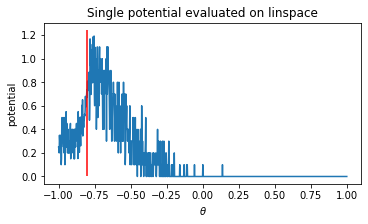

In [13]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.plot(thetas_linspace.numpy(), potential_thetas_linspace[0].exp().numpy())
ax.vlines(threshold, ymin=0.0, ymax=max(potential_thetas_linspace[0].exp())+0.05, color='r')
ax.set_ylabel('potential')
ax.set_xlabel(r'$\theta$')
ax.set_title("Single potential evaluated on linspace")
fig.savefig("./results/toy_example/active_learning/single_potential.pdf")

Text(0.5, 0, '$\\theta$')

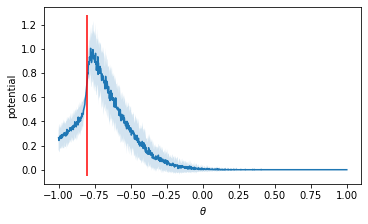

In [16]:
mean_potential = potential_thetas_linspace.exp().mean(dim=0)
std_potential = potential_thetas_linspace.exp().std(dim=0)

fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.plot(thetas_linspace.squeeze(), mean_potential)
ax.fill_between(thetas_linspace.squeeze().numpy(), (mean_potential-std_potential).numpy(), (mean_potential+std_potential).numpy(), alpha=0.2)
ax.vlines(threshold, ymin=-0.05, ymax=max(mean_potential+std_potential)+0.05, color='r')
ax.set_ylabel('potential')
ax.set_xlabel(r'$\theta$')
#ax.set_title(f"Mean and std over {n_potential} potentials evaluated on linspace")
#fig.savefig("./results/active_learning/toy_example_potential.pdf")

In [17]:
potentials_samples_proposal = potential(samples_proposal).exp()

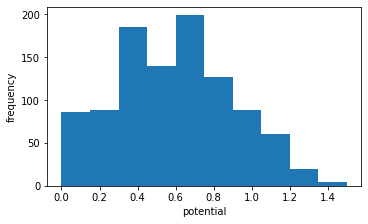

In [18]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.hist(potentials_samples_proposal.numpy())
ax.set_xlabel('potential')
ax.set_ylabel('frequency')
#ax.set_title(f"Histogram over potentials of {n_samples_proposal} samples from the proposal")
#fig.savefig("./results/active_learning/toy_example_potential_histogram.pdf")
plt.show()


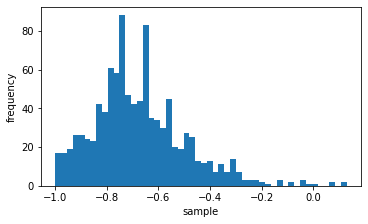

In [19]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.hist(torch.round(samples_proposal, decimals=2).numpy(), bins=50)
ax.set_xlabel('sample')
ax.set_ylabel('frequency')
#ax.set_title(f"Histogram over {n_samples_proposal} samples from the proposal")
#fig.savefig("./results/active_learning/toy_example_potential_samples_proposal.pdf")
plt.show()

Text(0, 0.5, 'potential')

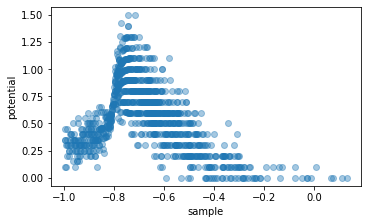

In [20]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.scatter(samples_proposal, potentials_samples_proposal, alpha=0.4)
ax.set_xlabel('sample')
ax.set_ylabel('potential')